# 1.  Data import

In [393]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [341]:
df_train = pd.read_csv("Dane.csv") # chinese 195 patients
df_test = pd.read_csv("Dane_test.csv") # chinese 79 patiens
df_test3 = pd.read_csv("Dane_test3.csv") # american 1038 patients

# Removing unnecessary colums
df_train = df_train[["outcome", "c_protein", "c_protein_change", "lactate", "lactate_change", "lymphocyte", "lymphocyte_change"]]
df_test = df_test[["outcome", "c_protein", "c_protein_change", "lactate", "lactate_change", "lymphocyte", "lymphocyte_change"]]
df_test3 = df_test3[["outcome", "c_protein", "c_protein_change", "lactate", "lactate_change", "lymphocyte", "lymphocyte_change"]]


#### Testing function

In [361]:
# Function for model score print
def model_metrics(Y, Y_pred):
    
    Metrics = []
    Metrics.append(accuracy_score(Y, Y_pred))
    Metrics.append(recall_score(Y, Y_pred))
    Metrics.append(precision_score(Y, Y_pred))
    Metrics.append(f1_score(Y, Y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(Y, Y_pred))
    print("###################")
    print("Accuracy: ", Metrics[0])
    print("Recall: ", Metrics[1])
    print("Precision: ", Metrics[2])
    print("F1: ", Metrics[3])
    
    return Metrics

In [103]:
# Function for rendering dataframe as table
def render_mpl_table(data, col_width=3.0, row_height=0.825, font_size=18,
                     header_color='#2c7fb8', row_colors=['#f9f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax


# 2. Chinese data

## 2.1  Logistic Regression

#### Data preparation


In [196]:
# Retrieving outcome column  
Y_train = df_train.outcome
X_train = df_train.drop("outcome", 1)

Y_test = df_test.outcome
X_test = df_test.drop("outcome", 1)

# Scaling datasets
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Model fitting

In [212]:
pipe = Pipeline([('classifier' , LogisticRegression())])

# Create param grid.
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.linspace(-1, 1, 80),
    'classifier__solver' : ['liblinear', 'lbfgs']}]

# Using GridSearch to tuning
clf_log = model_selection.GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=False,
                                       n_jobs=-1, scoring="f1")


best_clf_log = clf_log.fit(X_train_scaled, Y_train)

In [351]:
best_clf_log.best_estimator_

Pipeline(steps=[('classifier',
                 LogisticRegression(C=0.5949367088607596, solver='liblinear'))])

#### Model testing

In [357]:
log_preds = best_clf_log.predict(X_test_scaled)

log_score = model_metrics(Y_test, log_preds)

Confusion Matrix:
[[67  0]
 [ 2 10]]
###################
Accuracy:  0.9746835443037974
Recall:  0.8333333333333334
Precision:  1.0
F1:  0.9090909090909091


#### Checking coefficents

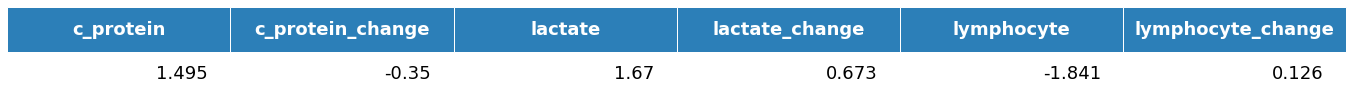

In [391]:
from pandas.plotting import table
import six

coefficents_log =  pd.DataFrame(np.around(best_clf_log.best_estimator_[0].coef_, 3))
coefficents_log.columns = ["c_protein", "c_protein_change", "lactate", 
                           "lactate_change", "lymphocyte", "lymphocyte_change"]


log_score_table = render_mpl_table(coefficents_log, header_columns=0, col_width=4.0)
plt.savefig("log_score.png")
plt.show()


## 2.2 Algorithm from article

#### Implementation

In [111]:
def tree(sample):
    if sample.lactate < 365:
        if sample.c_protein < 41.2:
            return 0
        else:
            if sample.lymphocyte > 14.7:
                return 0
            else:
                return 1
    else:
        return 1

#### Model Fitting

In [115]:
tree_preds = []
for i in range(len(X_test)):
    tree_preds.append(tree(X_test.iloc[i]))

#### Model Testing

In [358]:
tree_score = model_metrics(Y_test, tree_preds)

Confusion Matrix:
[[63  4]
 [ 1 11]]
###################
Accuracy:  0.9367088607594937
Recall:  0.9166666666666666
Precision:  0.7333333333333333
F1:  0.8148148148148148


## 2.3 Tabnet 

#### Data preparation

In [362]:
df_train_v = df_train.sample(math.floor(len(df_train) / 8)) # Validation set will be 1/5 of training set
df_train_t = df_train.drop(df_train_v.index) # Training sest

Y_train_t = df_train_t.outcome
X_train_t = df_train_t.drop("outcome", 1)

Y_train_v = df_train_v.outcome
X_train_v = df_train_v.drop("outcome", 1)

scaler = preprocessing.StandardScaler().fit(X_train_t)

X_train_t = scaler.transform(X_train_t)
X_train_v = scaler.transform(X_train_v)

#### Model Fitting

In [366]:
from pytorch_tabnet.tab_model import TabNetClassifier

clf_tab = TabNetClassifier()
clf_tab.fit(X_train_t, Y_train_t, eval_set = [(X_train_v, Y_train_v)])
tab_preds = clf_tab.predict(X_test_scaled)

Device used : cpu
epoch 0  | loss: 0.88079 | val_0_auc: 0.87143 |  0:00:00s
epoch 1  | loss: 0.55072 | val_0_auc: 0.93571 |  0:00:00s
epoch 2  | loss: 0.3741  | val_0_auc: 0.94286 |  0:00:00s
epoch 3  | loss: 0.28593 | val_0_auc: 0.97143 |  0:00:00s
epoch 4  | loss: 0.27815 | val_0_auc: 0.96429 |  0:00:00s
epoch 5  | loss: 0.26389 | val_0_auc: 0.94286 |  0:00:00s
epoch 6  | loss: 0.19913 | val_0_auc: 0.93571 |  0:00:00s
epoch 7  | loss: 0.17991 | val_0_auc: 0.92857 |  0:00:00s
epoch 8  | loss: 0.1418  | val_0_auc: 0.92857 |  0:00:00s
epoch 9  | loss: 0.14924 | val_0_auc: 0.90714 |  0:00:00s
epoch 10 | loss: 0.12584 | val_0_auc: 0.90714 |  0:00:00s
epoch 11 | loss: 0.10156 | val_0_auc: 0.91429 |  0:00:00s
epoch 12 | loss: 0.08898 | val_0_auc: 0.91429 |  0:00:00s
epoch 13 | loss: 0.06854 | val_0_auc: 0.91429 |  0:00:00s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.97143
Best weights from best epoch are automatically used!


#### Model Testing

In [367]:
tab_score = model_metrics(Y_test, tab_preds)

Confusion Matrix:
[[65  2]
 [ 2 10]]
###################
Accuracy:  0.9493670886075949
Recall:  0.8333333333333334
Precision:  0.8333333333333334
F1:  0.8333333333333334


#### Global Explainability

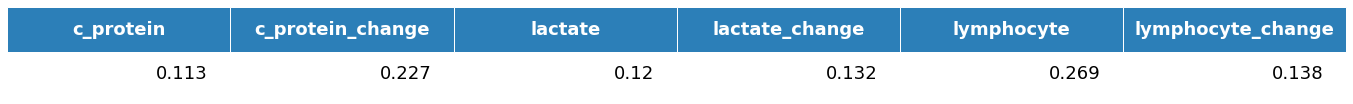

In [368]:
coefficents_tab = pd.DataFrame(np.around(clf_tab.feature_importances_, 3)).transpose()
coefficents_tab.columns = ["c_protein", "c_protein_change", "lactate", 
                           "lactate_change", "lymphocyte", "lymphocyte_change"]

tab_score_table = render_mpl_table(coefficents_tab, header_columns=0, col_width=4.0)
plt.savefig("tab_score.png")
plt.show()

#### Local Explainability

In [369]:
explain_matrix, masks = clf_tab.explain(X_test_scaled)

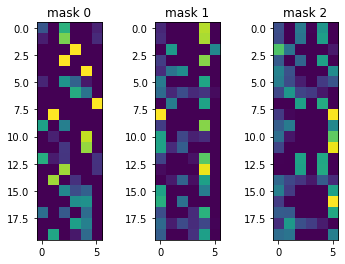

In [370]:
fig, ax = plt.subplots(1,3)
for i in range(3):
    ax[i].imshow(masks[i][:20])
    ax[i].set_title(f"mask {i}")
    
plt.savefig("tab_masks.png")
plt.show()

## 2.4 SVM

#### Model Fitting

In [371]:
from sklearn import svm

# Param Grid
param_grid = {'C': [0.1, 0.5, 1, 0.8, 2, 5, 10], 'gamma': np.linspace(0.01, 1, 50),'kernel': ['rbf', 'poly', 'sigmoid']}

# Tuning
clf_svm = model_selection.GridSearchCV(svm.SVC(), param_grid = param_grid, cv = 5, verbose=False,
                                       n_jobs=-1, scoring="f1")

best_clf_svm = clf_svm.fit(X_train_scaled,Y_train)

In [372]:
clf_svm.best_estimator_

SVC(C=1, gamma=0.1716326530612245, kernel='sigmoid')

In [373]:
svm_preds = clf_svm.predict(X_test_scaled)

#### Model Testing

In [374]:
svm_score = model_metrics(Y_test, svm_preds)

Confusion Matrix:
[[66  1]
 [ 1 11]]
###################
Accuracy:  0.9746835443037974
Recall:  0.9166666666666666
Precision:  0.9166666666666666
F1:  0.9166666666666666


## 2.5 Summary

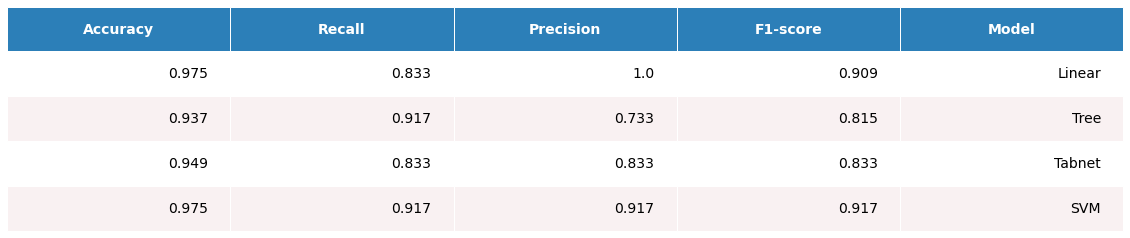

In [376]:
chinese_results = pd.DataFrame([np.around(log_score, 3), np.around(tree_score, 3),
                                np.around(tab_score, 3), np.around(svm_score, 3)], columns= ["Accuracy","Recall", "Precision", "F1-score"])
chinese_results["Model"] = ["Linear", "Tree", "Tabnet", "SVM"]

chinese_results_plot = render_mpl_table(chinese_results, header_columns=0, col_width=4.0, font_size= 14)
plt.savefig("chinese_results.png")
plt.show()

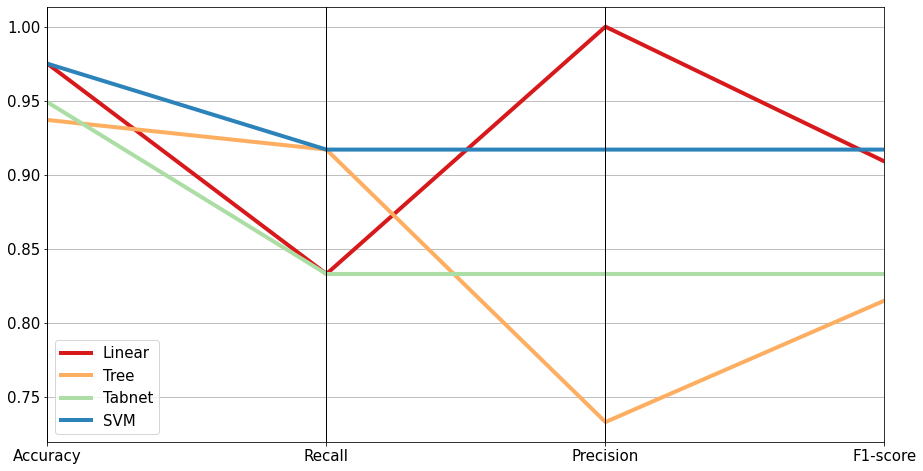

In [377]:
fig, ax = plt.subplots(figsize = (15, 8))
ax = pd.plotting.parallel_coordinates(chinese_results, 'Model', color=('#d7191c', '#fdae61', '#abdda4','#2b83ba'), linewidth = 4)
plt.legend(fontsize = 15)
ax.tick_params(axis = "both", which = "major", labelsize = 15)
plt.savefig("chinese_parallel.png")
plt.show()

# 3. American Data

## 3.1 Logistic Regression

#### Model Testing

In [378]:
Y_test3 = df_test3.outcome
X_test3 = df_test3.drop("outcome", 1)

X_test3 = scaler.transform(X_test3)

log_preds_3 = best_clf_log.predict(X_test3)



In [379]:
log_score_3 = model_metrics(Y_test3, log_preds_3)

Confusion Matrix:
[[359 319]
 [ 27 333]]
###################
Accuracy:  0.6666666666666666
Recall:  0.925
Precision:  0.5107361963190185
F1:  0.6581027667984191


## 3.2 Algorithm from article

In [380]:
Y_test3 = df_test3.outcome
X_test3 = df_test3.drop("outcome", 1)

tree_preds3 = []
for i in range(len(X_test3)):
    tree_preds3.append(tree(X_test3.iloc[i]))

In [381]:
tree_score_3 = model_metrics(Y_test3, tree_preds3)

Confusion Matrix:
[[262 416]
 [ 16 344]]
###################
Accuracy:  0.5838150289017341
Recall:  0.9555555555555556
Precision:  0.45263157894736844
F1:  0.6142857142857143


## 3.3 Tabnet

In [382]:
X_test3 = scaler.transform(X_test3)


tab_preds3 = clf_tab.predict(X_test3)

In [383]:
tab_score_3 = model_metrics(Y_test3, tab_preds3)

Confusion Matrix:
[[452 226]
 [ 72 288]]
###################
Accuracy:  0.7129094412331407
Recall:  0.8
Precision:  0.5603112840466926
F1:  0.6590389016018307


## 3.4 SVM

In [384]:
svm_preds3 = clf_svm.predict(X_test3)

In [385]:
svm_score_3 = model_metrics(Y_test3, svm_preds3)

Confusion Matrix:
[[384 294]
 [ 30 330]]
###################
Accuracy:  0.6878612716763006
Recall:  0.9166666666666666
Precision:  0.5288461538461539
F1:  0.6707317073170732


## 3.5 Summary

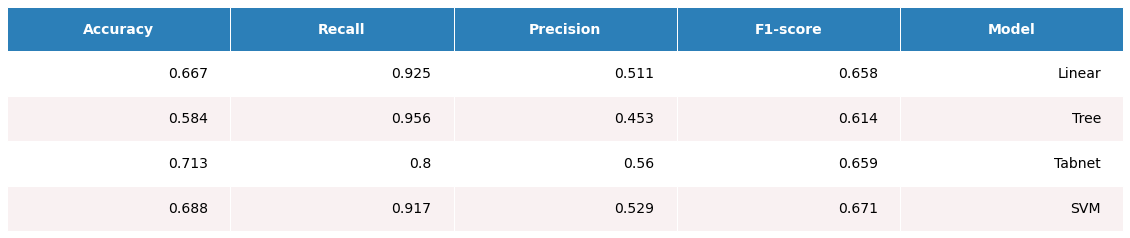

In [392]:
american_results = pd.DataFrame([np.around(log_score_3, 3), np.around(tree_score_3, 3),
                                np.around(tab_score_3, 3), np.around(svm_score_3, 3)], columns= ["Accuracy", "Recall", "Precision", "F1-score"])
american_results["Model"] = ["Linear", "Tree", "Tabnet", "SVM"]

american_results_plot = render_mpl_table(american_results, header_columns=0, col_width=4.0, font_size= 14)
plt.savefig("american_results.png")
plt.show()

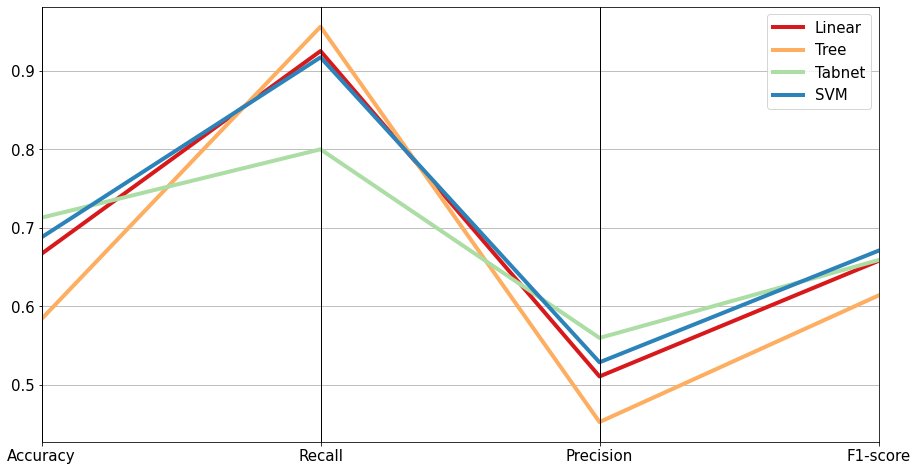

In [389]:
fig, ax = plt.subplots(figsize = (15, 8))
ax = pd.plotting.parallel_coordinates(american_results, 'Model', color=('#d7191c', '#fdae61', '#abdda4','#2b83ba'), linewidth = 4)
plt.legend(fontsize = 15)
ax.tick_params(axis = "both", which = "major", labelsize = 15)
plt.savefig("american_parallel.png")
plt.show()